# 3. Classification

In the previous section on __[regression](regression.ipynb)__ we addressed the goal of predicting a **continuous** output $\mathbf{y}^*$ given its input $\mathbf{x}^*$ and some training examples $\{\mathbf{x}_n, \mathbf{y}_n\}^N_{n = 1}$. In other problems however, the output $\mathbf{y}^*$ to be predicted is **discrete** instead of continuous, and represents the class to which the sample point belongs. For example, the class could be encoded in a vector $\mathbf{y}^*$ of length $K$ containing zeroes at $(K-1)$ of the entries and a single $1$ at some entry to denote the class to which the sample belongs.

Consider for example a flower classification problem where we are given a vector $\mathbf{x}^*$ with four continuous entries representing (sepal length, sepal width, petal length, petal width) of an Iris flower, and are asked to predict which class the flower belongs to out of three possibilities: iris setosa, viridia or virginica. This problem is based on the iconic __[Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)__. A more challenging classification problem is the __[MNIST handwritten digits](https://en.wikipedia.org/wiki/MNIST_database)__ database containing $28 \times 28$ pixel images of handwritten digits and corresponding labels, where the task is to predict the label of a digit from its image.

<div class="row">
  <div class="column">
    <img src="iris_matrix.svg" alt="Snow" style="width:50%; float: left; padding: 50px">
  </div>
  <div class="column">
    <img src="mnist.svg" alt="Forest" style="width:50%; float: right; padding: 50px">
  </div>
</div>

In this section we will be working on a subset of the Iris dataset, initially considering only the sepal length and sepal width as inputs and two out of three classes for simplicity. We will later ramp-up the problem to include all inputs and classes. 

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
# The usual notebook preferences
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from helper_functions import *
set_notebook_preferences()

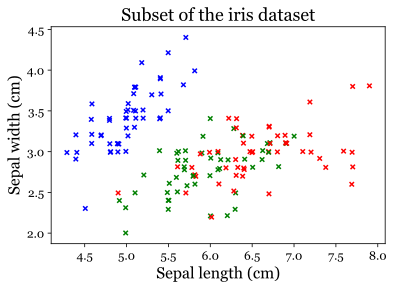

In [18]:
x = np.load('iris_inputs_2d.npy')
y = np.load('iris_labels.npy')

plt.scatter(x[:, 0], x[:, 1], marker = 'x', s = 20, color = np.array(['b', 'g', 'r'])[y])
beautify_plot({"title":"Subset of the iris dataset", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

# 3.1 k-nearest neighbours (kNN) algorithm

One initial algorithm is to classify any given point according to the membership of its closest point. That is to say given an unseen point $\mathbf{x}^*$, we would assign it to the class $c$ such that:

$$
\min\limits_{n}\big|\big|\mathbf{x}^* - \mathbf{x}_n\big|\big| \implies y^* = c
$$

There is an important question here which concerns how to define *closest* and in particular how to define *distance*. This issue is more obvious for a high-dimensional case, or a case where inputs have different units $-$ such as a dataset containing heights and weights of animals. In neither case is it clear that the usual Euclidian distance is the more appropriate way to tackle the problem. Some possibilities for our definition of distance are

\begin{align}
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \sum_{d} \big|x_{1,d} - x_{2,d}\big|,~\text{sum of absolute values ($L1$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^2\bigg]^{1/2},~\text{Euclidian distance ($L2$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^p\bigg]^{1/p},~\text{$p^{th}$ norm  ($Lp$ distance)}\\
\end{align}

**How could we choose the appropriate measure of distance?** We could test the candidate measures and pick the one which performs best on the training set, however for the moment let's stick with $L2$ and address this choice later. It is also worth noting that this method does not require any training: there are no parameters to optimise and the "training" effectively consists of storing the training set to compare with future datapoints $-$ making the algorithm easy to implement:

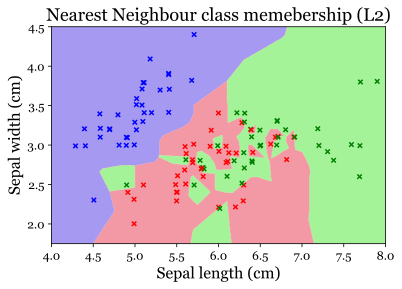

In [19]:
no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 500), np.linspace(1.75, 4.5, 500) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

cloned_grid = np.stack([grid] * no_train, axis = -2) # copy grid no_train times into a (500, 500, no_train, 2) array


# the whole algorithm is contained in these 3 lines
distances = np.sum((cloned_grid - x_train)**2, axis = -1) # compute L2 to get a (500, 500, no_train) array

idx = np.argmin(distances, axis = -1).reshape((-1,)) # find closest point to each training point, then flatten

classes = y_train[idx].reshape(500, 500) # classify each grid point according to the closest training point


plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4) # plot membership areas
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_train]) # plot data
beautify_plot({"title":"Nearest Neighbour class memebership (L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

The blue class is well separated from the red and green classes resulting in the large chunk of blue. However, the red and blue crosses are more intermixed, resulting in small islands of red membership in the green region and vice versa, which are caused by individual points. Having these small islands may or may not be reasonable, and we will shortly address this point. Before that, let's evaluate the algorithm's performance. **What should the accuracy of a random classification algorithm be?** Let's evaluate the test set accuracy:

In [10]:
x_test_clone = np.stack([x_test] * no_train, axis = -2) # clone test points into (no_test, no_train, 2) array

distances_test = np.sum((x_test_clone - x_train) ** 2, axis = -1) # compute L2 distances as before

idx = np.argmin(distances_test, axis = -1) # find closest point to each training point ()

classes_test = y_train[idx] # classify training points

accuracy = (classes_test == y_test).mean() * 100 # calculate classification accuracy
print("Classification accuracy on test set of {} points = {}%".format(y_test.shape[0], accuracy.round(2)))

Classification accuracy on test set of 38 points = 78.95%


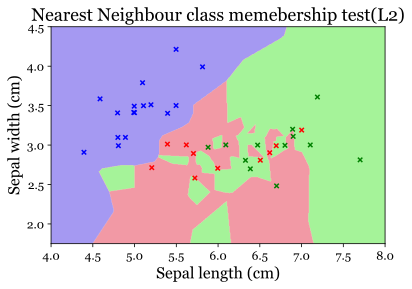

In [11]:
# plot class the memebrships and the test points
plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4)
plt.scatter(x_test[:, 0], x_test[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_test])
beautify_plot({"title":"Nearest Neighbour class memebership test(L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

A variation on this algorithm, that may produce smoother boundaries that account for the class overlap that is to be expected from such measurements, we can instead look at the \\(k\\) nearest neighbours for each unseen point \\(x^\star\\) for some value \\(k\\). We do this by choosing the most commonly occuring class among the \\(k\\) nearest neighbours, and using this as our estimate for the class of \\(x^\star\\). In the event that there are 2 or more classes with the most occurences, we choose randomly among these classes.

In [12]:
def kNN(X_train, Y_train, X_test, k, p = 2):
    
    X_test_clone = np.stack([X_test] * X_train.shape[0], axis = -2) # clone test points for comparisons as before
    
    distances = np.sum(np.abs(X_test_clone - X_train) ** p, axis = -1) # compute Lp distances
    
    idx = np.argsort(distances, axis = -1)[:, :k] # find k smallest distances
    
    classes = y_train[idx] # classes corresponding to the k smallest distances
    
    predictions = []
    
    for class_ in classes:
        
        uniques, counts = np.unique(class_, return_counts = True) # getting the set of classes, and counting the occurences
        
        if (counts == counts.max()).sum() == 1: # checking if there is a unique class with the most occurences in the kNN
            
            predictions.append(uniques[np.argmax(counts)]) # adding the class with the most occurences to predictions
            
        else:
            
            # if multiple classes have the maximum occurences in the kNN, choose randomly among them
            
            predictions.append(np.random.choice(uniques[np.where(counts == counts.max())[0]])) 
            
            
    return np.array(predictions) # return the predictions

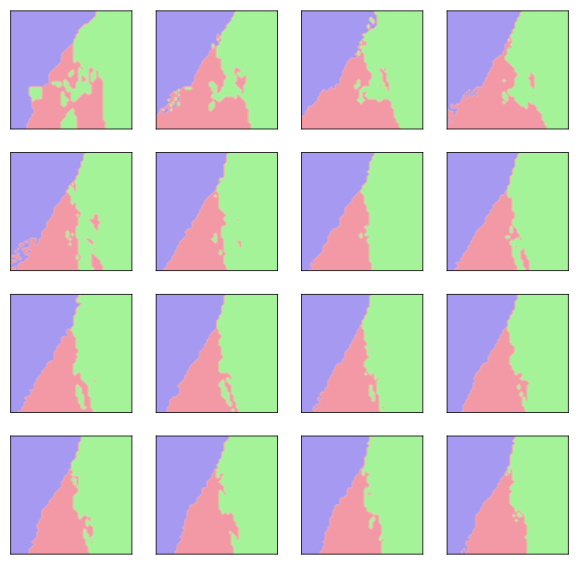

In [13]:
no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 50), np.linspace(1.75, 4.5, 50) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

flat_grid = grid.reshape((-1, x_train.shape[1])) # 

plt.figure(figsize  = (10, 10))

for k in range(16):

    classes = kNN(x_train, y_train, flat_grid, (k*2) + 1, p = 2) # call the kNN function to get the classes of the points

    plt.subplot(4, 4, k + 1)
    plt.contourf(s_len, s_wid, classes.reshape(grid.shape[:-1]), cmap = 'brg', alpha = 0.4) # plot membership areas
    remove_axes()
        
plt.show()

## 3.2 Probabilistic linear classification

One shortcoming of the kNN algorithm was having hard descision boundaries. What if instead of assigning every point to a single class, we estimated the probabilities that the said point belongs to each class? For concreteness, our goal in this probabilistic approach is: given a dataset $\{\mathbf{x}_n,\mathbf{y}_n\}$ to map a given input $\mathbf{x^*}$ to $K$ numbers $\{p^*_k\}_{k=1}^K$ which are the probabilites of the datapoint belonging to each class for $K$ classes.

For simplicity, we will consider the special case of a two-class problem, and will later show how this approach generalizes to more classes. A real-world example of a two-class classification problem might be a spam e-mail filter that classifies email as either spam or not spam. Let $y_n$ be a binary variable denoting the class of the $n^{th}$ point: $y_n = 0$ means it belongs to the first class (not spam) and $y_n = 1$ to the second class (spam). Under a probabilistic *linear* model we model the membership as

$$
p(y_n = 1 | \mathbf{x}_n, \mathbf{w}) = \sigma(\mathbf{w}^\top \mathbf{x}_n)
$$

where $\sigma(\cdot)$ is a monotonic increasing function which takes values between $0$ and $1$, and $\mathbf{w}$ is the weights vector.
    
This approach is referred to as *linear* classification because the descision boundaries $-$ i.e. the contours of constant $p(y_n = 1| \mathbf{x}_n, \mathbf{w})$ are linear in $\mathbf{x}$-space $-$ which is because the argument $\mathbf{w}^\top \mathbf{x}_n$ is linear in $\mathbf{x}$.

With regards to $\sigma(\cdot)$, two choices are common:

- The *logistic* function, $\sigma(x) = \frac{1}{1 + \text{exp}(-x)}$.


- The *probit* function, $\sigma(x) = \int_{-\infty}^x \mathcal{N}(z|0, 1) dz$.

<div class="row">
  <div class="column">
    <img src="logit_probit.svg" alt="Snow" style="width:50%; float: center; padding: 0px">
  </div>
</div>

In this example we will be using the logistic function, for which our model is written as:

$$
p(y_n = 1| \mathbf{x}, \mathbf{w}) = \frac{1}{1 + \text{exp}({-\mathbf{w}^\top \mathbf{x}})}
$$

Using such a linear classification model with a logistic function may both appear overly simplistic, however there is good reason for these choices, provided as extra details for the enthusiasts.

<details>
<summary>Why choose a linear model with the logistic function</summary>
<div>
Suppose the class conditional probabilities $p(\mathbf{x}| \mathcal{C}_k)$ of the datapoints are given by

\begin{align}
p(\mathbf{x}| y_k = 1) = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}}\text{exp}\bigg\{-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top\boldsymbol{\Sigma}^{-1}(\mathbf{x} - \boldsymbol{\mu}_k)\bigg\}
\end{align}

where $y_k = 1$ denotes denotes membership to the $k^{th}$ class. In other words, the members of a given class are sampled from a multivariate normal, and all such multivariate models share the same covariance matrix $\boldsymbol{\Sigma}$. By Bayes’ rule

\begin{align}
p(y_k = 1 | \mathbf{x}) = \frac{p(\mathbf{x}| y_k = 1)p(y_k = 1)}{\sum_j p(\mathbf{x}| y_j = 1)p(y_j = 1)}
\end{align}

In the two-class case this becomes

\begin{align}
p(y_1 = 1 | \mathbf{x}) = \frac{1}{1 +  \text{exp}(-a)} = \sigma(a),~ a = \text{ln}\bigg(\frac{p(\mathbf{x}| y_1 = 1)p(y_1 = 1)}{p(\mathbf{x}| y_2 = 1)p(y_2 = 1)}\bigg)
\end{align}

where $\sigma$ is the logistic function. Substituting the expressions for $p(\mathbf{x}| y_k = 1)$ into the expression for $a$, we note that terms which are quadratic in $\mathbf{x}$ will cancel out from the numerator and denominator because they involve the same covariance matrix $\boldsymbol{\Sigma}$. Also, the logarithm will cancel the exponential making $a$ linear with $\mathbf{x}$. It is left as an exercise to show that

\begin{align}
a &= \mathbf{w}^\top \mathbf{x} + w_0,\\
\mathbf{w} &= \Sigma^{-1}(\mu_1 - \mu_2),\\
w_0 &= -\frac{1}{2}\boldsymbol{\mu}_1^\top \Sigma^{-1} \boldsymbol{\mu}_1 + \frac{1}{2}\boldsymbol{\mu}_2^\top \Sigma^{-1} \boldsymbol{\mu}_2 + \text{ln}\frac{p(y_1 = 1)}{p(y_2 = 1)}
\end{align}

Although the linearity of the decision boundary does not hold in the general case where $\boldsymbol{\Sigma}$ is not identical for all classes, this result provides some motivation in using the logistic function with an argument which is linear in $\mathbf{w}$.
</div>
</details>

The next question is how to go about learning the weights $\mathbf{w}$, given the training examples $\{\mathbf{x}_n, y_n\}^N_{n=1}$. We can proceed via the maximum likelihood approach, where the aim is to maximize:

$$
p(\mathbf{y}|\{\mathbf{x}_n\} \mathbf{w}) = \prod^N_{n = 1} p(y_n|\mathbf{x}_n, \mathbf{w})
$$

Using our expression for $p(y_n|\{\mathbf{x}_n\}, \mathbf{w})$ and the convinient fact that $y_n$ is either $0$ or $1$ depending on the class of the sample, we can write the likelihood as $-$ 

$$
p(\mathbf{y}|\{\mathbf{x}_n\} \mathbf{w}) = \prod^N_{n = 1} \sigma(\mathbf{w}^\top\mathbf{x}_n)^{y_n} \big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)^{1-y_n}
$$

you might want to take time to convince yourself of this. As we previously stated in the regression section, maximizing the log-likelihood (or minimizing the negative log-likelihood) is equivalent to maximizing the likelihood. Here it is easiest to maximize the log-likelihood: 

$$
\mathcal{L} =\text{log}~p(\mathbf{y}|\{\mathbf{x}_n\} \mathbf{w}) = \sum^N_{n = 1} \left[ y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big) \right]
$$

To do this, we have to find the minimum turning point. We can attempt to do this by taking the derivative of $\mathcal{L}$ with respect to $\mathbf{w}$, using the handy result for the derviative of the logistic function:

\begin{align}
\frac{\partial \sigma(x)}{\partial x} = \frac{e^{-x}}{(1 + e^{-x})^2} = \big(1 - \sigma(x)\big)\sigma(x)
\end{align}

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} &= \frac{\partial}{\partial \mathbf{w}} \sum^N_{n = 1} \left[ y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\right]\\
~\\
&= \sum^N_{n = 1} \left[ y_n \big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n - (1-y_n)\sigma(\mathbf{w}^\top\mathbf{x}_n)\mathbf{x}_n\right]\\
~\\
&= \sum^N_{n = 1} \big(y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n\\
\end{align}

Although it may not be immediately obvious, at this point we've run into some trouble: the expression for $\partial \mathcal{L}/\partial \mathbf{w}$ involves a sum of sigmoids, which means that a closed form solution to $\partial \mathcal{L}/\partial \mathbf{w} = 0$ cannot be written out. We can still make progress in practice however, by employing a method called *gradient ascent* $-$ which is just the nomenclature for saying that we will update $\mathbf{w}$ using the gradient $\partial \mathcal{L}/\partial \mathbf{w}$ as follows:

\begin{align}
\mathbf{w}_{n+1} = \mathbf{w}_{n} + \eta\frac{\partial \mathcal{L}}{\partial \mathbf{w}}\bigg|_{\mathbf{w}_{n}}
\end{align}

where $\eta$ is often called the stepsize or learning rate. Choosing an appropriate learning rate is important to ensure the algorithm converges $-$ we will deal with this later. It is also worth pointing out that this method of maximizing $\mathcal{L}$ is not the only way: there are a host of different approaches which can be used for this optimization problem. 

Let's see what an implementation of gradient ascent might look like.

In [5]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        
        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks) 

Lets now apply this algorithm to a $1$D extraction of the iris dataset. We do this, simply because it is easier to visualise, as there are only two weights to learn for such a dataset (constant $w_0$ and coefficient $w_1$), which we can easily visualize. It contains $40$ datapoints labeled $y = 0,~\text{or}~1$, which we will be splitting half-half in a test and a train dataset.

In [6]:
x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')

x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

w_0 = np.array([0.0, 0.0]) # set initial weights to 0

w_history, log_liks = gradient_ascent(x_train, y_train, w_0, 10 ** 2, 1) # calling the function on the dataset

print('Weights before:', w_0.round(2), ' and after:', w_history[-1].round(2))

Weights before: [0. 0.]  and after: [ 1.89 -2.17]


The weights have certaintly changed, but are we at the maximum liklihood (or at least close to it)? Let's also plot the evolution of $\mathcal{L}$ with the iteration step, and the before/after sigmoids in the space of the data.

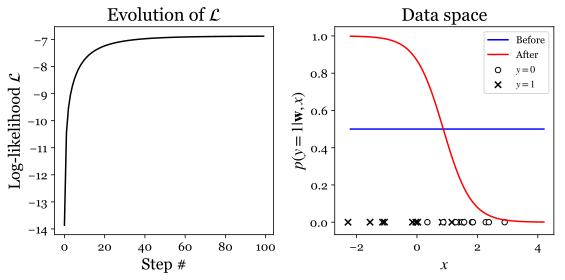

In [7]:
# here we plot the data

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(log_liks, color = 'black') # plot log likelihoods
beautify_plot({"title":r"Evolution of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})

plt.subplot(1, 2, 2)

x_1, x_2 = x_train[np.where(y_train == 0)[0]], x_train[np.where(y_train == 1)[0]]

xs = np.linspace(-2.2, 4.2, 100)

plt.plot(xs, sig(xs * w_history[0, 1] + w_history[0, 0]), color = 'blue', zorder = 3, label = 'Before')
plt.plot(xs, sig(xs * w_history[-1, 1] + w_history[-1, 0]), color = 'red', zorder = 3, label = 'After')

plt.scatter(x_1, np.zeros_like(x_1), color = 'white', edgecolor = 'black', marker = 'o', s = 30,
            zorder = 2, label = '$y = 0$')
plt.scatter(x_2, np.zeros_like(x_2), color = 'black', marker = 'x', s = 40, zorder = 1, label = '$y = 1$')

beautify_plot({"title":r"Data space", "x":"$x$", "y":"$p(y = 1|\mathbf{w}, x)$"})
plt.gca().legend()
plt.tight_layout()
plt.show()

In the plot above, the gradient ascent algorithm converges quickly, starting to plateau within the first 20 iterations. After optimisation, the initially flat likelihood function has changed into a sigmoid. This next animation shows what is happening during the training:

<div class="row">
  <div class="column">
    <img src="class_1d_animation.gif" style="width:100%; float: center; padding: 0px">
  </div>
</div>

As the gradient ascent progresses, we can see the weights $(w_0, w_1)$ climb up the likelihood, in a direction normal to the contours. The log-likelihood $\mathcal{L}$ rapidly increases at first and then flattens out as $(w_0, w_1)$ approach the maximum likelihood. Close to the maximum likelihood, the gradient $\partial \mathcal{L}/\partial \mathbf{w}$ becomes smaller and smaller, so the optimiser is taking miniscule steps towards, and appears to converge at, the maximum. One question which may be raised at this point is whether this maximum is global or local: in fact there is a single (global) maximum in all such probabilistic linear classification problems $-$ a sketch proof is given bellow for enthusiasts only.

<details>
<summary>Global maximum in probabilistic linear classification</summary>
<div>
In order to prove that there is a unique global maximum of the likelihood given by:
    
$$
p(\mathbf{y}|\{\mathbf{x}_n\} \mathbf{w}) = \prod^N_{n = 1} \sigma(\mathbf{w}^\top\mathbf{x}_n)^{y_n} \big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)^{1-y_n}
$$

We prove that the negative log likelihood has a global minimum, which in turn proves the likelihood has a global maximum. The negative log likelihood can be written as follows:

-

</div>
</details>

And now for the moment of truth, let's see how well our classifier performs on the test set $-$ so far we've only looked at what happens during optimisation. Since we'll want to test our model's accuracy on the iris dataset too, we'll write this up as a function:

In [8]:
def test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = sig(x_.dot(w))
    return 1 - abs((y_.round() - test_y)).mean()

print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

Classifier accuracy for 1D dataset = 80.0%


## Full iris dataset

Now that we have an idea of how the gradient ascent optimisation works, let's apply it to the full Iris dataset. Thus far our classification model only works for datasets with two classes, but each data point in the iris dataset belongs to one of $3$ classes (either $0$,$1$ or $2$) so we'll remove all data points of class '$2$', to give us a two class dataset where each element is labelled either $0$ or $1$. We'll also do a test-train split. We have already done all the hard work, and simply call the function we wrote before:

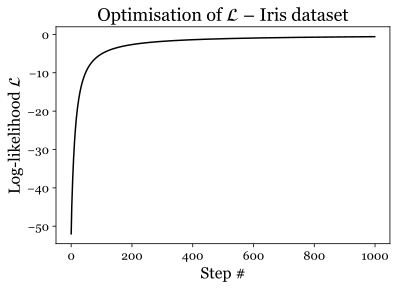

In [26]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2

no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

w_history, log_liks = gradient_ascent(x_train, y_train, np.array([0.0]*(x.shape[1]+1)), 1000, 0.1) # calling the gradient ascent function
plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$ $-$ Iris dataset",
               "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.show()

Again, the gradient ascent has converged, however in this case it has converged to a larger $\mathcal{L}$ than in the 1D example, indicating that our model now fits the training data more closely, as expected since we have more degrees of freedom. **Here link to the case study containing below case study and examination of the full dataset**

In [10]:
print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

Classifier accuracy for 1D dataset = 100.0%


In [13]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 1))[0]]
y = y[np.where(np.logical_not(y == 1))[0]]

y[np.where(y == 2)[0]] = 1

no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

Classifier accuracy for 1D dataset = 100.0%


In [14]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 0))[0]]
y = y[np.where(np.logical_not(y == 0))[0]]
y[np.where(y == 2)[0]] = 0

no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

Classifier accuracy for 1D dataset = 40.0%


<div class="row">
  <div class="column">
    <img src="class_iris_animation.gif" style="width:80%; float: center; padding: 0px">
  </div>
</div>

In the above animation, each subplot corresponds to a pair of input features. For example the plot in (row, column) = (1, 2) has feature $1$ as the x-axis and feature $2$ as the y-axis. Note that the whole picture is symmetric, so that (i, j) and (j, i) are really the same plot, just reflected along the "$y = x$" line. The coloured background which changes with time is a contour plot visualisation of the probability, where red means high $\approx 1$ and blue means low $\approx 0$ probability. It's worthwhile understanding how the probability was visualised to get a better idea of what the plots show. First, the weights of the current optimisation step were used to evaluate the single-point probability

$$
p(y = 1|\mathbf{w}, \mathbf{x}) = \sigma(\mathbf{w}^\top\mathbf{x})
$$

at several points on a 4-dimensional grid. Then in order to visualise the likelihood in the plane of features $i$ and $j$, the other two axes were eliminated by calculating the mean of the likelihood along these two axes. For example, to plot likelihood contours in the plane of features $(1, 3)$, axes $2 \text{ and } 4$ were eliminated by averaging the likelihood over them, for each point in the $(1, 3)$ plane. The resulting contours are shown above. We see that as the optimisation progresses, the descision boundary changes to accomodate the data.

## Multi-class classification (soft max)

We will now see how to extend this probablistic linear model to deal with multiple classes. **Change phrasing plus example** Consider the $1$-of-K scheme where $y_{nk} = 0 \text{ or } 1$ denotes whether datapoint $n$ belongs to class $k$. In other words if $y_{nk}$ is written out as a matrix, each row will contain a single $1$ and all other entries will be $0$. We also need a multiclass likelihood funcion $f(a)$ to replace the logistic function $\sigma(a)$ which could only deal with two classes. As a reminder, the argument $a$ is a linear function of the weights and features: $a = \mathbf{w}^\top \mathbf{x}$. The generalisation of the logistic function to multiple classes is called the *softmax* function:

$$
p(y_{nk} = 1 |\{\mathbf{x}_n\}, \{\mathbf{w}_k\}) = \frac{\text{exp}(a_k)}{\sum_j \text{exp}(a_j)} = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_j \text{exp}(\mathbf{w}_j^\top \mathbf{x}_n)},
$$

where instead of a single weight vector we now have several weight vectors $\{\mathbf{w}_k\}$, one for each class. It can be shown that setting $K = 2$ results in the original logistic function $-$ left as an excercise to the reader. In fact, the argument used earlier when evaluating the logistic function can be used to justify the form of the softmax. **add this as exercise**

The likelihood of the full dataset and then the log-likelihood $\mathcal{L}$ can then be written out:

\begin{align}
p(y_{nk} = 1 |\{\mathbf{x}_n\}, \{\mathbf{w}_k\}) &= \prod_{n = 1}^N \prod_{k = 1}^K s_{nk}^{y_{nk}}\\
~\\
\mathcal{L} &= \sum_{n = 1}^N \sum_{k = 1}^K y_{nk} \text{log}~s_{nk},
\end{align}

Where we have written $s_{nk} = \text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)\big/\sum_j \text{exp}(\mathbf{w}_j^\top \mathbf{x}_n)$. Now we can proceed by gradient ascent again, which amounts to finding the derivatives of $\mathcal{L}$ with respect to the weights. The derivative of the soft-max can be shown to be

\begin{align}
\frac{\partial s_{nk}}{ \partial a_{nj}} = s_{nk}(I_{kj} - s_{nj})
\end{align}

Which together with the expression can be used to show that

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} = \sum^N_{n = 1} (y_{nj} - s_{nj}) \mathbf{x}_n
\end{align}

<details>
<summary>Gradient of softmax log-likelihood</summary>
<div>
    Starting from the expression

\begin{align}
\mathcal{L} &= \sum_{n = 1}^N \sum_{k = 1}^K y_{nk} \text{log}~s_{nk},
\end{align}

and taking the derivative w.r.t. $\mathbf{w}_j$ we see:


\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} \frac{1}{s_{nk}} \frac{\partial s_{nk}}{\partial \mathbf{w}_j} = \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} \frac{1}{s_{nk}} \frac{\partial s_{nk}}{\partial a_{nj}} \frac{\partial a_{nj}}{\mathbf{w}_j}\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} (I_{kj} - s_{nj}) \mathbf{x}_n\\
~\\
\end{align}

where we have used the expression

\begin{align}
\frac{\partial s_{nk}}{ \partial a_{nj}} = s_{nk}(I_{kj} - s_{nj}).
\end{align}

Then considering that for each $n$, $y_{nk}$ is $1$ for a single value of $k$ and $0$ for all other values of $k$:


\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk}(I_{kj} - s_{nj})\mathbf{x}_n\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K (y_{nj} - s_{nj})\mathbf{x}_n\\
\end{align}

arriving at the final result.
</div>
</details>

Let's write down gradient ascent for the softmax as we did for the logistic function.

In [27]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function for convenience

def softmax_gradient_ascent(x, y, init_weights, no_steps, stepsize):
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as before
    
    w = init_weights.copy() # copy weights as before
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods as before

    for n in range(no_steps): # in this part we optimise log-lik w.r.t. ws
        
        log_liks.append(np.sum(y*np.log(softmax(x.dot(w))))) # record current log-lik as before
        
        w_history.append(w.copy()) # record current weights as before
    
        soft_ = softmax(x.dot(w)) # using our neat convenience function
        
        dL_dw = (x.T).dot(y - soft_)/x.shape[0]
        
        w += stepsize*dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks)

We can now implement gradient ascent on the whole dataset iris dataset, with all the parameters, and all 3 classes:

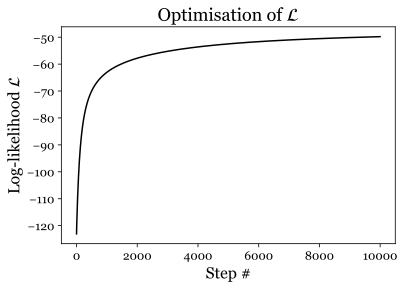

In [29]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train, :2], x[no_train:, :2], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.plot(log_liks, color = 'black')
plt.show()

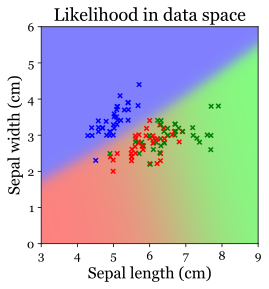

In [30]:
min_x, max_x, min_y, max_y, res = 3, 9, 0, 6, 1000
grid = np.stack(np.meshgrid(np.linspace(min_x, max_x, res), np.linspace(min_y, max_y, res)), axis = -1)
grid = grid.reshape((-1, 2))
grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)

probs = softmax(grid.dot(w_history[-1])).reshape((res, res, 3))
rgb_colors = np.roll(probs, -1, axis  = -1)
plt.imshow(rgb_colors, extent = [min_x, max_x, min_y, max_y], alpha = 0.5, origin='lower')
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y[:no_train]])
beautify_plot({"title":r"Likelihood in data space", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

In [31]:
def softmax_test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = softmax(x_.dot(w))
    return (np.argmax(y_, axis = 1) == np.argmax(y_test, axis = 1)).mean()

softmax_test_accuracy(x_test, y_test, w_history[-1])

0.8421052631578947

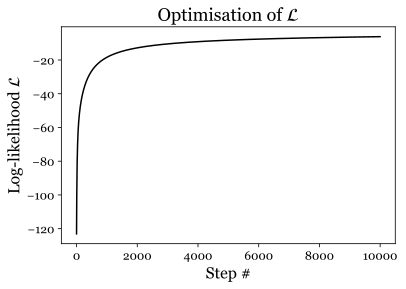

0.9473684210526315

In [34]:
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.plot(log_liks, color = 'black')
plt.show()
softmax_test_accuracy(x_test, y_test, w_history[-1])

## Bayesian logistic regression

Previously we have been using gradient ascent to find weights $\mathbf{w}$ which maximise the log-likelihood $\mathcal{L}$ and we now turn to a Bayesian treatment of logistic regression. Re-iterating our recipe for Bayesian approaches:

1. Write down the likelihood $p(\mathcal{D}|\mathbf{w})$ of the generative model.
2. Assume a prior $p(\mathbf{w})$ over the parameter(s) of the model.
3. Apply Bayes' rule to find the posterior $p(\mathbf{w}|\mathcal{D})$.
4. Calculate the predictive distribution $p(y^*| \mathcal{D})$.

We have already looked at step 1 here; this is just the likelihood of the complete dataset. Regarding the prior (step 2), in the regression example we picked a gaussian conjugate prior, in order to aid calculations down the line. Here however, the form of the likelihood makes exact inference intractable $-$ that's why we used gradient ascent $-$ and it is not possible to find a prior conjugate to this likelihood. Let us then assume an isotropic gaussian prior with mean $0$ and covariance matrix $\boldsymbol{\Sigma}_0 = \lambda I$ over the model weights. Step 3 is now more challenging than in regression where the gaussian form of the likelihood and prior gave an exact closed form for the posterior, so our calculation will need to be approximate. There are several ways to go about this approximation, one of which is to use the Laplace approximation which amounts to approximating the likelihood using a multivariate gaussian. The approximate posterior will then also be gaussian, and from there we will be able to obtain the predictive distribution $p(y^*| \mathcal{D})$ in step 4. To summarise, for logistic regression our approach will be

1. Likelihood $p(\mathcal{D}|\mathbf{w})$ as obtained already.
2. Assume a gaussian prior $\mathcal{N}(\mathbf{w}; 0, \boldsymbol{\Sigma}_0)$.
3. Apply the Laplace approximation $p(\mathcal{D}|\mathbf{w}) \approx \mathcal{N}(\mathbf{w}; \boldsymbol{\mu}, \boldsymbol{\Sigma})$ and use it to calulate an approximation of the posterior $p(\mathbf{w}|\mathcal{D})$.
4. Calculate the approximate predictive distribution $p(y^*| \mathcal{D})$.

## Laplace approximation

Consider a distribution $p(z)$ with its mode at $z_0$. Expanding the logarithm of $p(z)$, remembering that the linear term will vanish because we are at a maximum:

\begin{align}
\text{log}~p(z) \approx \text{log}~p(z_0) + \frac{1}{2}(z - z_0)^2\frac{d^2}{dz^2}\text{log}~p(z)
\end{align}

The Laplace approximation of $p(z)$ is the gaussian which has its mean at the mode of $p(z)$, and a variance $\sigma^2$ to match the quadratic coefficient of the above expansion. For a gaussian we have

\begin{align}
\text{log}~\mathcal{N}(z; z_0, \sigma^2) = \text{const. } - \frac{1}{2\sigma^2}(z - z_0)^2
\end{align}

so we will pick $1/\sigma^2 = - d^2/dz^2\text{log}~p(z)$, so that the second-order term of the (exact) expansion of the gaussian matches the corresponding term in the approximate expansion of $p(x)$. Let's work through the example distribution

\begin{align}
p(z) = \frac{a}{\pi}\frac{1}{a^2 + z^2}~\text{ (already normalised).}
\end{align}

The mode of this distribution is at $z = 0$ and the second derivative at $z = 0$ is

\begin{align}
\frac{d^2 p(z)}{dz^2} = \bigg[ \frac{4z^2}{(a^2 + z^2)^2} - \frac{2}{a^2 + z^2} \bigg]_{z = 0} = -\frac{2}{a^2}
\end{align}

Therefore the Laplace approximation of this distribution is a gaussian with its mean at 0 and a variance $\sigma^2 = a^2/2$:

$$
\mathcal{N}(z; 0, a^2/2)
$$

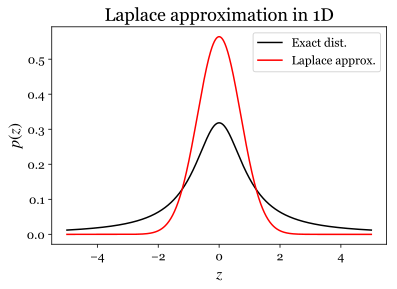

In [22]:
a = 1
z_ = np.linspace(-5, 5, 1000)
p_ = a/(np.pi * (a**2 + z_**2))
gaussian = 1/(np.pi*a**2)**0.5 * np.exp(-1/a**2*z_**2)

plt.plot(z_, p_, color = 'black', label = 'Exact dist.')
plt.plot(z_, gaussian, color = 'red', label = 'Laplace approx.')
beautify_plot({"title":r"Laplace approximation in 1D", "x":"$z$", "y":"$p(z)$"})
plt.gca().legend(fontsize = 12)
plt.show()

** add laplace approximation examples**

In this example, the approximating gaussian decays as $e^{-z^2}$ whereas the exact distribution decays much slower, as $1/(z^2)$. Since both distributions must be normalised, this means that the Laplace approximation must have a higher peak than the example distribution, the later being more spread out along the x-axis.

For a multivariate distribution $p(\mathbf{z})$, the Laplace approximation is a multivariate gaussian. We pick the mean of the approximating gaussian to be the mode of the exact distribution. The covariance matrix is again given in terms of the expansion of $\text{log}~p(\mathbf{z})$:

\begin{align}
\text{log}~p(\mathbf{z}) &\approx \text{log}~p(\mathbf{z}_0) + \frac{1}{2}\sum_i\sum_j (z_j - z_{0i})^2\frac{d}{dz_i}\frac{d}{dz_j}\text{log}~p(x)\\
~\\
&= \text{log}~p(\mathbf{z}_0) + \frac{1}{2} (\mathbf{z} - \mathbf{z}_0)^\top \bigg[\nabla \nabla \text{log}~p(x)\bigg] (\mathbf{z} - \mathbf{z}_0)\\
\end{align}

In the case of a multivariate gaussian:

\begin{align}
\text{log}~q(\mathbf{z}) = \text{const. } - \frac{1}{2} (\mathbf{z} - \mathbf{z}_0)^\top \boldsymbol{\Sigma}^{-1} (\mathbf{z} - \mathbf{z}_0)\\
\end{align}

So comparing the two expansions we obtain

\begin{align}
\boldsymbol{\Sigma}^{-1} = -\nabla \nabla \text{log}~p(x).\\
\end{align}

The matrix $\nabla \nabla \text{log}~p(x)$ is a Hessian Matrix (a matrix containing the double derivatives of a quantity as its entries) and is often referred to by this name.

## Laplace approximation applied to Bayesian logistic regression

To apply the Laplace approximation to the posterior, we need to determine the mode of the posterior and calculate the Hessian at that mode. The exact solution to the maximum of the posterior is intractable, but we can use gradient ascent to approximate the mode of the posterior as we did with the likelihood $-$ the only difference being that in the posterior there will be a term from the pior in the expression we are maximizing. Using a gaussian prior $\mathcal{N}(\mathbf{w}; \mathbf{m}_0, \boldsymbol{\Sigma}_0)$ we can write the logarithm of the posterior using Bayes rule:

\begin{align}
p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &\propto p(\{\mathbf{y}_n, \mathbf{x}_n\} | \mathbf{w}) p(\mathbf{w})\\
~\\
\text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= -\frac{1}{2} (\mathbf{w} - \mathbf{m}_0)^\top \boldsymbol{\Sigma}^{-1}_0(\mathbf{w} - \mathbf{m}_0) + \sum^N_{n = 1} y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\\
~\\
\nabla \text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= -\boldsymbol{\Sigma}^{-1}_0(\mathbf{w} - \mathbf{m}_0) + \sum^N_{n = 1} \big(y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n\\
~\\
\boldsymbol{\Sigma}^{-1} = -\nabla \nabla \text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= \boldsymbol{\Sigma}^{-1}_0 + \sum^N_{n = 1} \sigma(\mathbf{w}^\top\mathbf{x}_n)\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n \mathbf{x}_n^\top\\
\end{align}

The Laplace approximation then takes the form $\mathcal{N}(\mathbf{w}; \mathbf{w}_{MAP}, \boldsymbol{\Sigma})$. We can now evaluate the predictive distribution:

\begin{align}
p(y^* = 1| \mathbf{x}^*, \{y_n, \mathbf{x}_n\}) &= \int p(y^* = 1| \mathbf{x}^*, \mathbf{w}) p(\mathbf{w} | \{y_n, \mathbf{x}_n\})d\mathbf{w} = \int \sigma(\mathbf{w}^\top\mathbf{x}) p(\mathbf{w} | \{y_n, \mathbf{x}_n\})d\mathbf{w}\\
&\approx \int \sigma(\mathbf{w}^\top\mathbf{x}) q(\mathbf{w})d\mathbf{w}\\
&= \int \int \sigma(a)\delta(a - \mathbf{w}^\top\mathbf{x})da~q(\mathbf{w})d\mathbf{w}\\
&= \int \sigma(a)p(a)da, \text{ where }~p(a) = \int \delta(a - \mathbf{w}^\top\mathbf{x})q(\mathbf{w})d\mathbf{w}\\
\end{align}

Our expression for distribution $p(a)$ can be simplified by noting that the Dirac-delta $\delta(a - \mathbf{w}^\top\mathbf{x})$ imposes a linear constraint on $\mathbf{w}$ so the effect of the integral $\int \delta(a - \mathbf{w}^\top\mathbf{x}) q(\mathbf{w}) d\mathbf{w}$ is to integrate out $\mathbf{w}$ along all directions orthogonal to $\mathbf{x}$. Since a marginal of a gaussian is also a gaussian the resulting distribution $p(a)$ will also be gaussian, and it suffices to find its mean and variance to fully characterise it:


\begin{align}
\mu_a &= \int a p(a) da = \int a \int \delta(a - \mathbf{w}^\top\mathbf{x}) q(\mathbf{w}) d\mathbf{w} da = \int  \mathbf{w}^\top\mathbf{x} q(\mathbf{w}) d\mathbf{w} = \mathbf{w}_{MAP}^\top\mathbf{x}\\
~\\
\sigma_a^2 &= \int \big(a^2 - \mu_a^2\big)p(a) da = \int \big(a^2 - \mu_a^2\big)\delta(a - \mathbf{w}^\top\mathbf{x})q(\mathbf{w}) d\mathbf{w} da = \int \big((\mathbf{w}^\top\mathbf{x})^2 - (\mathbf{w}_{MAP}^\top\mathbf{x})^2\big)q(\mathbf{w}) d\mathbf{w}\\
&= \int (\mathbf{w}^\top\mathbf{x})^2 q(\mathbf{w}) d\mathbf{w} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top \bigg[\int\mathbf{w}\mathbf{w}^\top q(\mathbf{w}) d\mathbf{w} \bigg]\mathbf{x} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top\bigg[\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top + \Sigma \bigg] \mathbf{x} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top\Sigma\mathbf{x}
\end{align}

Therefore $p(a) = \mathcal{N}(a; \mathbf{w}_{MAP}, \mathbf{x}^\top\Sigma\mathbf{x})$. Still the integral $\int \sigma(a)\mathcal{N}(a; \mathbf{w}_{MAP}, \mathbf{x}^\top\Sigma\mathbf{x})da$ is the convolution of a sigmoid with a gaussian and cannot be evaluated explicitly, so another approximation must be made. In particular, approximating the sigmoid using the probit function:

$$\sigma(a) \approx \Phi(\lambda a) = \int_{-\infty}^{\lambda a} \mathcal{N}(z|0, 1) dz$$

where the scaling constant $\lambda$ is picked such that the gradients of $\sigma(a)$ and $\Phi(\lambda a)$ are equal at the origin:

<div class="row">
  <div class="column">
    <img src="logit_probit_scaled.svg" alt="Snow" style="width:50%; float: center; padding: 0px">
  </div>
</div>

This approximation does not appear to be very severe; the scaled probit and sigmoid seem to be quite similar. Under this approximation, it can be shown that the predictive distribution integral is equal to another scaled probit:

\begin{align}
\int \sigma(a)\mathcal{N}(a; \mu, \sigma^2)da &\approx \int \Phi(\lambda a)\mathcal{N}(a; \mu, \sigma^2)da\\
&= \Phi\Bigg(\frac{\mu}{(\lambda^{-2} + \sigma^2)^{1/2}}\Bigg), \text{ where } \mu = \mathbf{w}_{MAP}^\top \mathbf{x}, ~\sigma^2 = \mathbf{x}^\top\Sigma\mathbf{x}\\
\end{align}

Let's apply this Bayesian approach on the $1$D example we saw previously to visualise the prior, likelihood and posterior distsributions.

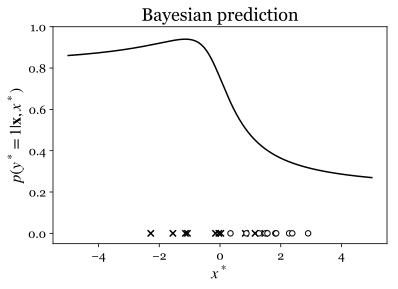

In [25]:
x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')
x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

w_history, log_liks = gradient_ascent(x_train, y_train, np.zeros(shape = 1 + x.shape[-1]), 10**2, 1)
w_map = w_history[-1]

x_ = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = -1)
sigs = sig(x_.dot(w_map))
cov_0 = np.eye(2)*1
cov = cov_0 + (sigs*(1 - sigs)*x_.T).dot(x_)

xs = np.stack([np.ones(shape = (2000,)), np.linspace(-5, 5, 2000)], axis = 1)
mu = xs.dot(w_map)
var = np.sum((xs).dot(cov)*xs, axis = -1)

from scipy.stats import norm
probit = norm.cdf(xs)
probit_scaled = norm.cdf(mu/(8/np.pi + var)**0.5)

x_1, x_2 = x_train[np.where(y_train == 0)[0]], x_train[np.where(y_train == 1)[0]]
plt.scatter(x_1, np.zeros_like(x_1), color = 'white', edgecolor = 'black', marker = 'o', s = 30,
            zorder = 2, label = '$y = 0$')
plt.scatter(x_2, np.zeros_like(x_2), color = 'black', marker = 'x', s = 40, zorder = 1, label = '$y = 1$')
plt.plot(xs[:, 1], probit_scaled, color = 'black')
beautify_plot({"title":r"Bayesian prediction", "x":"$x^*$", "y":"$p(y^* = 1|\mathbf{x}, x^*)$"})
plt.ylim([-0.05, 1])
plt.show()

## Non-linear logistic regression



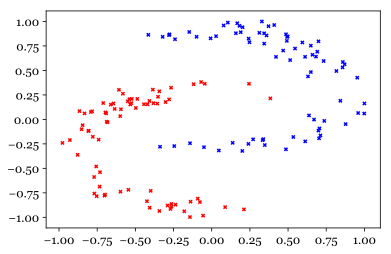

In [20]:
x = np.load('class_crescent_inputs.npy')
y = np.load('class_crescent_labels.npy')
no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

class_0, class_1 = np.where(y_train == 0), np.where(y_train == 1)
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)
plt.show()

In [21]:
lengthscale = 0.2
no_x, no_y = 10, 10
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*x_train.shape[0], axis = 0)

points = np.stack([x_train]*no_x*no_y, axis = 1).reshape((x_train.shape[0], no_x, no_y, 2))
phi = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((x_train.shape[0], -1))

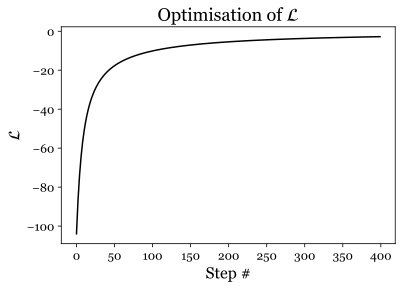

In [22]:
w_history, log_liks = gradient_ascent(phi, y_train, np.zeros(shape = (no_x*no_y + 1,)), 400, 1)

plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"$\mathcal{L}$"})
plt.show()

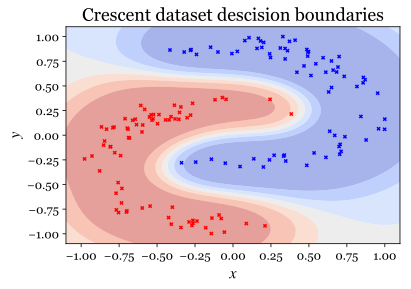

In [23]:
test_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100)), axis = 2).reshape((-1, 2))
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*test_grid.shape[0], axis = 0)

points = np.stack([test_grid]*no_x*no_y, axis = 1).reshape((test_grid.shape[0], no_x, no_y, 2))
phi_ = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((test_grid.shape[0], -1))
phi_pred = np.append(np.ones(shape = (phi_.shape[0], 1)), phi_, axis = -1)


pred = sig(phi_pred.dot(w_history[-1])).reshape(100, 100)
plt.contourf(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100),
             pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)
beautify_plot({"title":r"Crescent dataset descision boundaries", "x":"$x$", "y":"$y$"})
plt.show()

In [24]:
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*x_test.shape[0], axis = 0)

points = np.stack([x_test]*no_x*no_y, axis = 1).reshape((x_test.shape[0], no_x, no_y, 2))
phi = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((x_test.shape[0], -1))

test_accuracy(phi, y_test, w_history[-1])

1.0